<a href="https://colab.research.google.com/github/Cynthia3992/Deep-Learning-Course/blob/master/training_at_level_cc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip  install tf-nightly-2.0-preview

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os
import io
# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

import tensorflow.keras.applications as applications
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190512


### Global constants

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 160 
BATCH_SIZE = 25

CLASS_MODE = 'categorical'

NUM_OF_CLASSES = 2
CLASS_NAMES = ['tumor', 'non_tumor']


### Setting up GCP

In [0]:
GCP_PROJECT_ID = 'triple-voyage-239123'
GCP_BUCKET_NAME = 'vaa2114_dl_2019'

In [64]:
!gcloud config set project {GCP_PROJECT_ID}

Updated property [core/project].


### Read Data from GCP

In [0]:
LEVEL = 5

In [0]:
TRAIN_DIR = "/tmp/train/"
GCP_TRAIN_DIR = "train/level{}/".format(LEVEL)
LEVEL_TRAIN_DIR = "/tmp/train/level{}".format(LEVEL)

TEST_DIR = "/tmp/test/"
GCP_TEST_DIR = "test/level{}/".format(LEVEL)
LEVEL_TEST_DIR = "/tmp/test/level{}".format(LEVEL)

In [0]:
!rm -rf '$TRAIN_DIR'
!rm -rf '$TEST_DIR'

!mkdir -p '$TRAIN_DIR'
!mkdir -p '$TEST_DIR'

In [0]:
WINDOW = 800

### Download Level data into Train/Test Directories

In [9]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TRAIN_DIR} {TRAIN_DIR}
  
print("\nDownloaded Train Data")

print("# Non Tumor files")
!ls "$LEVEL_TRAIN_DIR/non_tumor/" | wc -l
print("# Tumor files")
!ls "$LEVEL_TRAIN_DIR/tumor/" | wc -l

Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_108800_tumor_078.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_217600_tumor_035.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_217600_tumor_057.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_96000_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_12800_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_19200_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_19200_tumor_101.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_096.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_101.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_32000_tumor_096.tif...
Copying gs://vaa2114_dl_201

In [10]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TEST_DIR} {TEST_DIR}
  
print("\nDownloaded Test Data")

print("# Non Tumor files")
!ls "$LEVEL_TEST_DIR/non_tumor/" | wc -l
print("# Tumor files")
!ls "$LEVEL_TEST_DIR/tumor/" | wc -l

Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_0_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_0_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_217600_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_121600_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_0_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_12800_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_128000_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_0_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_134400_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_12800_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_19200_tumor_084.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_256

In [11]:
train_tumor_dir = os.path.join(LEVEL_TRAIN_DIR, "tumor")
train_non_tumor_dir = os.path.join(LEVEL_TRAIN_DIR, "non_tumor")

val_tumor_dir = os.path.join(LEVEL_TEST_DIR, "tumor")
val_non_tumor_dir = os.path.join(LEVEL_TEST_DIR, "non_tumor")


tot_train_tumor = len(os.listdir(train_tumor_dir))
tot_train_non_tumor = len(os.listdir(train_non_tumor_dir))

tot_val_tumor = len(os.listdir(val_tumor_dir))
tot_val_non_tumor = len(os.listdir(val_non_tumor_dir))

total_train = tot_train_tumor + tot_train_non_tumor
total_val = tot_val_tumor + tot_val_non_tumor

print(total_train)
print(tot_train_tumor)
print(tot_val_tumor)

858
197
68


In [0]:
!find /tmp/train/level5/non_tumor -type f -print0 | sort -zR | tail -zn +151 | xargs -0 rm
!find /tmp/train/level5/tumor -type f -print0 | sort -zR | tail -zn +151 | xargs -0 rm

!find /tmp/test/level5/non_tumor -type f -print0 | sort -zR | tail -zn +51 | xargs -0 rm
!find /tmp/test/level5/tumor -type f -print0 | sort -zR | tail -zn +51 | xargs -0 rm

### Util functions

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [0]:
def getModel(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(216, activation='relu'))
  model.add(Dense(NUM_OF_CLASSES, activation='softmax'))
  
  return model

In [0]:
# Compile and build

def trainModel(model, total_train, total_val, 
               train_data_gen, val_data_gen, EPOCHS):
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

  history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
        epochs=EPOCHS,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
        verbose=2)
  
  return history

In [0]:
# Print Train/Validate accuracy and loss

def plotTrainVal(history, EPOCHS):

  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, EPOCHS+1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Image Generators w/ Data Augmentation

In [22]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 160
BATCH_SIZE = 32
NUM_CLASSES = 2

CLASS_MODE = 'categorical'

image_gen_train = ImageDataGenerator(rescale=1./255)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_TRAIN_DIR, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode=CLASS_MODE)



# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_TEST_DIR,                     # Using Test data for validation
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode=CLASS_MODE)

# Test data should not be augmented!
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=LEVEL_TEST_DIR, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode=CLASS_MODE)

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Sample Training Data after Data Augmentation

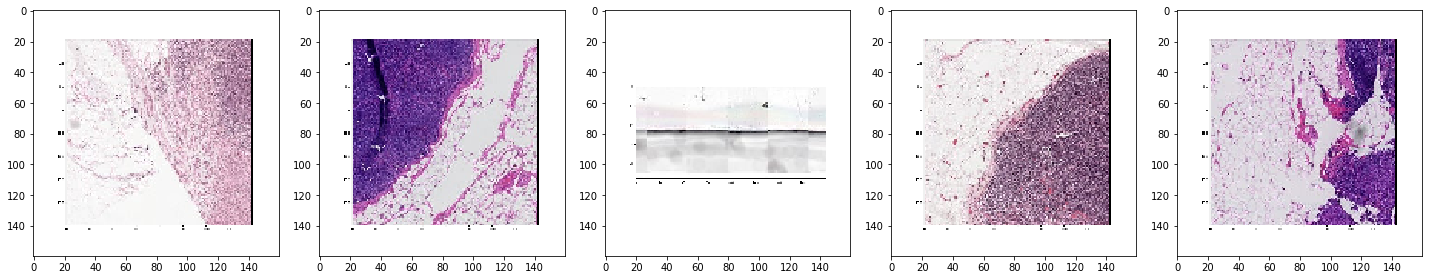

In [23]:
sample_training_images, sample_training_labels = next(train_data_gen)

plotImages(sample_training_images[:5])

### Sample Validation data

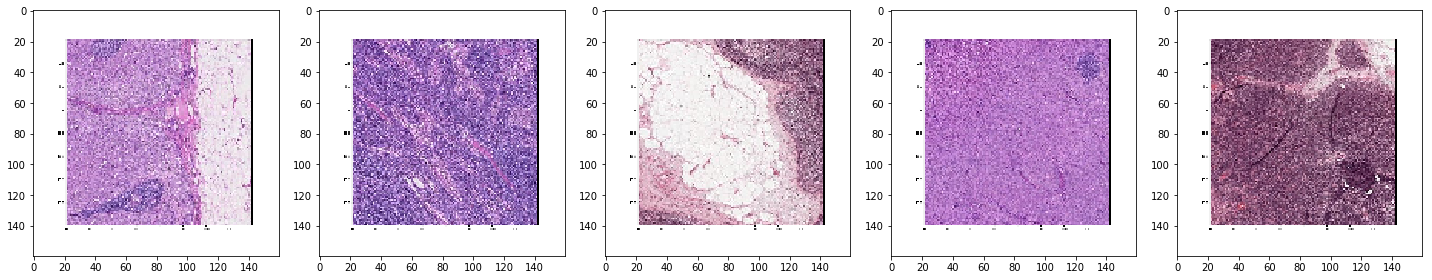

In [24]:
sample_val_images, sample_val_labels = next(val_data_gen)

plotImages(sample_val_images[:5])

### Sample Test Data

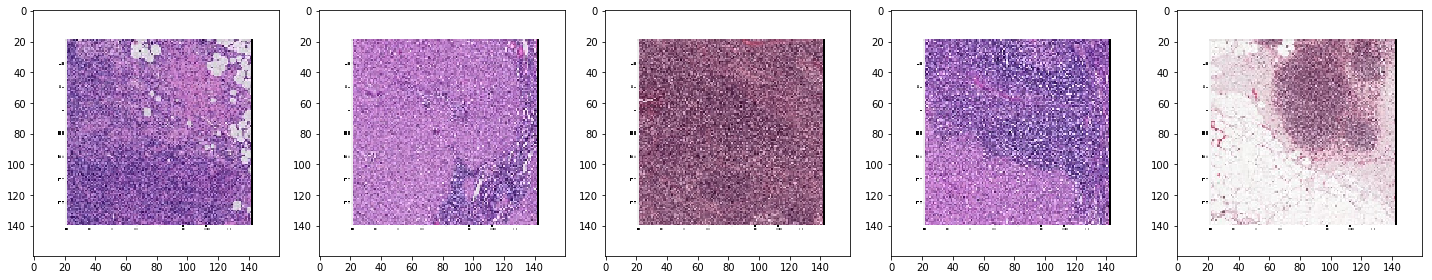

In [25]:
sample_test_images, sample_test_labels = next(test_data_gen)

plotImages(sample_test_images[:5])

### Train with Mobile Net

In [26]:
mobile_net = applications.MobileNetV2(weights='imagenet',include_top=False, input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))

conv_base = mobile_net
conv_base.trainable = False

model_mobile = getModel(conv_base)

9412608/9406464 [==============================] - 3s 0us/step


In [27]:
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 216)               6912216   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 434       
Total params: 9,170,634
Trainable params: 6,912,650
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
%%time

EPOCHS = 10

history_mobile = trainModel(model_mobile, total_train, total_val,  
           train_data_gen, val_data_gen, EPOCHS)

Epoch 1/10
27/27 - 79s - loss: 0.0276 - acc: 0.9938 - val_loss: 6.5304 - val_acc: 0.5043
Epoch 2/10
27/27 - 74s - loss: 0.1710 - acc: 0.9684 - val_loss: 5.8359 - val_acc: 0.5474
Epoch 3/10
27/27 - 72s - loss: 0.1840 - acc: 0.9776 - val_loss: 6.4454 - val_acc: 0.5259
Epoch 4/10
27/27 - 69s - loss: 0.1027 - acc: 0.9769 - val_loss: 5.3178 - val_acc: 0.6034
Epoch 5/10
27/27 - 72s - loss: 0.1142 - acc: 0.9809 - val_loss: 5.2595 - val_acc: 0.5776
Epoch 6/10
27/27 - 73s - loss: 0.0641 - acc: 0.9867 - val_loss: 5.6509 - val_acc: 0.5690
Epoch 7/10
27/27 - 68s - loss: 0.0605 - acc: 0.9900 - val_loss: 6.2302 - val_acc: 0.5776
Epoch 8/10
27/27 - 73s - loss: 0.0466 - acc: 0.9913 - val_loss: 8.3091 - val_acc: 0.5129
Epoch 9/10
27/27 - 73s - loss: 0.0195 - acc: 0.9925 - val_loss: 5.7096 - val_acc: 0.5603
Epoch 10/10
27/27 - 74s - loss: 0.0529 - acc: 0.9915 - val_loss: 7.6794 - val_acc: 0.5776
CPU times: user 23min 21s, sys: 16.4 s, total: 23min 37s
Wall time: 12min 7s


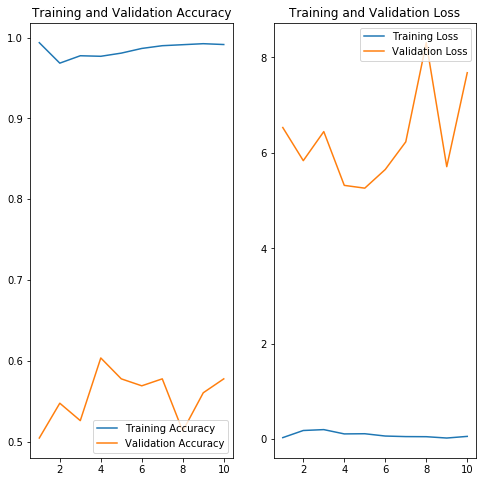

In [30]:
plotTrainVal(history_mobile, EPOCHS)

Confusion matrix, without normalization
[[ 2 11]
 [ 0 19]]


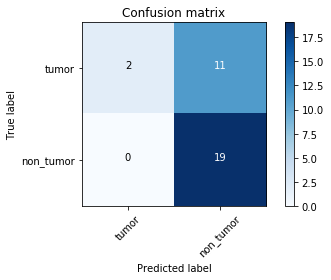

In [31]:
predictions_mobile = model_mobile.predict(sample_test_images)
y_pred_1= np.argmax(predictions_mobile, axis=1)

confusion_matrix_mobile = confusion_matrix(np.argmax(sample_test_labels, axis=1), y_pred_1)
plot_confusion_matrix(confusion_matrix_mobile, CLASS_NAMES)

### Save Model

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
def save_model_to_gcp(model, model_name):
   
  
  # Save Keras ModelCheckpoints locally
  model.save(os.path.join("/tmp", model_name))


  # Copy over to Google Cloud Storage
  BLOB_DESTINATION = os.path.join("model", model_name)
  blob = BUCKET_.blob(BLOB_DESTINATION)
  blob.upload_from_filename(os.path.join("/tmp", model_name))
  
  # gcs url to uploaded matplotlib image
  url = blob.public_url
  
  print("model saved at {}".format(url))



In [93]:
model_name = "level{}_window_{}.h5".format(LEVEL, WINDOW)
save_model_to_gcp(model_mobile, model_name)



model saved at https://storage.googleapis.com/vaa2114_dl_2019/model/level5_window_800.h5


### LOAD MODELS

In [94]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{MODEL} {"/tmp"}

Copying gs://vaa2114_dl_2019/model/level5_window_800.h5...
- [1/1 files][ 88.0 MiB/ 88.0 MiB] 100% Done                                    
Operation completed over 1 objects/88.0 MiB.                                     


In [0]:
level5_window_800 = load_model('/tmp/model/level5_window_800.h5')

Confusion matrix, without normalization
[[ 2 11]
 [ 0 19]]


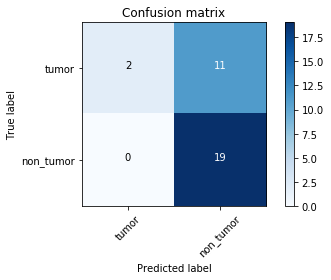

In [96]:
predictions_mobile = level5_window_800.predict(sample_test_images)
y_pred_1= np.argmax(predictions_mobile, axis=1)

confusion_matrix_mobile = confusion_matrix(np.argmax(sample_test_labels, axis=1), y_pred_1)
plot_confusion_matrix(confusion_matrix_mobile, CLASS_NAMES)